# Introduction

This notebook is a continuation of the first one, `Image Translation using CycleGAN`. I will tune the first CycleGan model a bit, and continue training, and then submit the newly generated images to Kagge to see if the results improve.

Since this is a separate notebook, I will load the data and build the model as I did in `Image Translation using CycleGAN`, and then load the weights from the first model.

In [1]:
# Import packages 
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Layer, Input, Conv2D, Conv2DTranspose, GroupNormalization 
from keras.layers import Activation, ReLU, LeakyReLU, Add
from keras.optimizers import Adam
from keras.ops import pad, ones_like, zeros_like
from keras.utils import register_keras_serializable
from keras.losses import MeanSquaredError, MeanAbsoluteError
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers.schedules import PolynomialDecay

### Load the data

In [2]:
# Define a function to decode images from TFRecord files
def decode_img(img):
    image = tf.io.decode_jpeg(img, channels = 3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256, 256, 3])
    return image

# Define a function to read images from TFRecord files
def read_tfrecord(tfdata):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    tfdata = tf.io.parse_single_example(tfdata, tfrecord_format)
    image = decode_img(tfdata['image'])
    return image

# Define a function to load images from the TFRecord files
def load_dataset(filenames):
    # disable order, increase speed
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False   
    
    # read images from multiple files if available
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

In [3]:
# Get the file names from monet_tfrec and photo_tfrec
monet_file = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
photo_file = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

# Load the datasets
monet_ds = load_dataset(monet_file).batch(1)
photo_ds = load_dataset(photo_file).batch(1)

In [4]:
# Define a function to prepare the data 
def CycleGan_dataset(monet_dataset, photo_dataset):
    monet_ds = monet_dataset.repeat()
    photo_ds = photo_dataset.repeat()
   
    monet_ds = monet_ds.shuffle(2048)
    photo_ds = photo_ds.shuffle(2048)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

# Get the training set 
CycleGan_ds = CycleGan_dataset(monet_ds, photo_ds)

### Build CycleGAN model

In [5]:
# Weights initializer for the layers
kernel_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

# Weights initializer for the instance normalization
gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

# Define a function for downsampling block
def downsample(x, filters, kernel_size, strides, activation = 'relu'):
    x = Conv2D(filters, kernel_size, strides = strides, padding = 'same',
                     kernel_initializer = kernel_init, use_bias = False)(x)
    x = GroupNormalization(groups = filters, gamma_initializer = gamma_init)(x)    # Instance Normalization
    x = Activation(activation)(x)
    return x

# Define a function for upsampling block
def upsample(x, filters, kernel_size, strides, activation = 'relu'):
    x = Conv2DTranspose(filters, kernel_size, strides = strides, padding = 'same',
                     kernel_initializer = kernel_init, use_bias = False)(x)
    x = GroupNormalization(groups = filters, gamma_initializer = gamma_init)(x)  
    x = Activation(activation)(x)
    return x

# Define a layer of reflection padding via subclassing
@register_keras_serializable()
class reflection_padding(Layer):
    def __init__(self, padding = (1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)
        
    def call(self, input_tensor):
        pad_x, pad_y = self.padding
        pad_width = [
            [0, 0],              # no padding on batch axis
            [pad_y, pad_y],      # padding on image height axis
            [pad_x, pad_x],      # padding on image width axis
            [0, 0]               # no padding on channel axis
        ]
        return pad(input_tensor, pad_width, mode = "reflect")
        
    def get_config(self):
        config = super.get_config()
        config.update({"padding": self.padding})
        return config

# Define a layer of residule block via subclassing
@register_keras_serializable()
class residual_block(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.padding = reflection_padding()

    def build(self, input_shape):
        filters = input_shape[-1]
        self.conv1 = Conv2D(filters, kernel_size = (3, 3), 
                            kernel_initializer = kernel_init, use_bias = False)
        self.conv2 = Conv2D(filters, kernel_size = (3, 3), 
                            kernel_initializer = kernel_init, use_bias = False)
        self.instance_norm1 = GroupNormalization(groups = filters, gamma_initializer = gamma_init)
        self.instance_norm2 = GroupNormalization(groups = filters, gamma_initializer = gamma_init)

    def call(self, inputs):
        input_tensor = inputs
        # first conv block
        x = self.padding(inputs)
        x = self.conv1(x)
        x = self.instance_norm1(x)
        x = Activation('relu')(x)
        
        # second conv block
        x = self.padding(x)
        x = self.conv2(x)
        x = self.instance_norm2(x)
        x = Activation('relu')(x)

        # output
        x = Add()([input_tensor, x])
        return x

    def get_config(self):
        return super.get_config()   

In [6]:
# Build the generator
def generator(filters = 64, num_downsample = 2, num_residual = 9, num_upsample = 2, name = None):
    inputs = Input(shape = [256, 256, 3])
    # First convolutional block 
    x = reflection_padding(padding = (3, 3))(inputs)
    x = Conv2D(filters, kernel_size = (7, 7), kernel_initializer = kernel_init, use_bias = False)(x)
    x = GroupNormalization(groups = filters, gamma_initializer = gamma_init)(x)
    x = Activation('relu')(x)

    # Downsampling block
    for _ in range(num_downsample):
        filters *= 2
        x = downsample(x, filters, (3, 3), (2, 2), activation = 'relu')

    # Residual block
    for _ in range(num_residual):
        x = residual_block()(x)

    # Upsampling block
    for _ in range(num_upsample):
        filters //= 2
        x = upsample(x, filters, (3, 3), (2, 2), activation = 'relu')

    # Final block
    x = reflection_padding(padding = (3, 3))(x)
    x = Conv2D(3, kernel_size = (7, 7), kernel_initializer = kernel_init, use_bias = False)(x)
    x = GroupNormalization(groups = 3, gamma_initializer = gamma_init)(x)
    x = Activation('tanh')(x)

    return Model(inputs = inputs, outputs = x)

In [7]:
# Build the discriminator
def discriminator(filters = 64, num_downsample = 3, name = None):
    inputs = Input(shape = [256, 256, 3])
    # First convolutional block
    x = Conv2D(filters, kernel_size = (4, 4), strides = (2, 2), padding = 'same',
               kernel_initializer = kernel_init, use_bias = False)(inputs)
    x = Activation('leaky_relu')(x)

    # Downsampling block
    for _ in range(num_downsample):
        filters *= 2
        x = downsample(x, filters, (4, 4), (2, 2), activation = 'leaky_relu')   

    # Final block
    x = Conv2D(1, kernel_size = (4, 4), padding = 'same',
               kernel_initializer = kernel_init, use_bias = False)(x)

    return Model(inputs = inputs, outputs = x)

In [8]:
# Define the functions of adversarial loss
def generator_loss(dis_fake):
    loss_fn = MeanSquaredError()
    return loss_fn(ones_like(dis_fake), dis_fake)

def discriminator_loss(dis_real, dis_fake):
    loss_fn = MeanSquaredError()
    real_loss = loss_fn(ones_like(dis_real), dis_real)
    fake_loss = loss_fn(zeros_like(dis_fake), dis_fake)
    return (real_loss + fake_loss) * 0.5

# Define the function of cycle consistency loss
def cycle_loss(img, cycled_img, Lambda):
    loss_fn = MeanAbsoluteError()
    return Lambda * loss_fn(img, cycled_img)

# Define the function of identity loss
def identity_loss(img, same_img, Lambda):
    loss_fn = MeanAbsoluteError()
    return 0.5 * Lambda *  loss_fn(img, same_img)

In [9]:
# Build the CycleGAN model via subclassing
class CycleGAN(Model):
    def __init__(self, generator_monet, generator_photo, discriminator_monet, 
                 discriminator_photo, lambda_cycle = 10):
        super().__init__()
        self.GenM = generator_monet
        self.GenP = generator_photo
        self.DisM = discriminator_monet
        self.DisP = discriminator_photo
        self.Lamd = lambda_cycle
        
    def compile(self, 
                genM_optimizer, genP_optimizer, disM_optimizer, disP_optimizer,
                gen_loss, dis_loss, cycle_loss, identity_loss):
        super().compile()
        self.GenM_Opt = genM_optimizer
        self.GenP_Opt = genP_optimizer
        self.DisM_Opt = disM_optimizer
        self.DisP_Opt = disP_optimizer
        self.gen_loss = gen_loss
        self.dis_loss = dis_loss
        self.cycle_loss = cycle_loss
        self.identity_loss = identity_loss

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent = True) as tape:
            # photo → monet → photo
            fake_monet = self.GenM(real_photo, training = True)
            cycled_photo = self.GenP(fake_monet, training = True)

            # monet → photo → monet
            fake_photo = self.GenP(real_monet, training = True)
            cycled_monet = self.GenM(fake_photo, training = True)

            # identity mapping
            same_monet = self.GenM(real_monet, training = True)
            same_photo = self.GenP(real_photo, training = True)
            
            # discriminator output
            dis_real_monet = self.DisM(real_monet, training = True)
            dis_fake_monet = self.DisM(fake_monet, training = True)
            dis_real_photo = self.DisP(real_photo, training = True)
            dis_fake_photo = self.DisP(fake_photo, training = True)

            # generator adversarial loss
            genM_adver = self.gen_loss(dis_fake_monet)
            genP_adver = self.gen_loss(dis_fake_photo)

            # cycle loss
            cycle_photo = self.cycle_loss(real_photo, cycled_photo, self.Lamd)
            cycle_monet = self.cycle_loss(real_monet, cycled_monet, self.Lamd)
            total_cycle = cycle_photo + cycle_monet

            # identity loss
            genM_identity = self.identity_loss(real_monet, same_monet, self.Lamd)
            genP_identity = self.identity_loss(real_photo, same_photo, self.Lamd)

            # total generator loss
            genM_loss = genM_adver + total_cycle + genM_identity
            genP_loss = genP_adver + total_cycle + genP_identity

            # discriminator loss
            disM_loss = self.dis_loss(dis_real_monet, dis_fake_monet)
            disP_loss = self.dis_loss(dis_real_photo, dis_fake_photo)

        # calculate gradients for generators
        grads_GenM = tape.gradient(genM_loss, self.GenM.trainable_variables)
        grads_GenP = tape.gradient(genP_loss, self.GenP.trainable_variables)
            
        # calculate gradients for discriminators
        grads_DisM = tape.gradient(disM_loss, self.DisM.trainable_variables)
        grads_DisP = tape.gradient(disP_loss, self.DisP.trainable_variables)

        # update weights of generators and discriminators
        self.GenM_Opt.apply_gradients(zip(grads_GenM, self.GenM.trainable_variables))
        self.GenP_Opt.apply_gradients(zip(grads_GenP, self.GenP.trainable_variables))
        self.DisM_Opt.apply_gradients(zip(grads_DisM, self.DisM.trainable_variables))
        self.DisP_Opt.apply_gradients(zip(grads_DisP, self.DisP.trainable_variables))

        return {
            "genM_loss": genM_loss,
            "genP_loss": genP_loss,
            "disM_loss": disM_loss,
            "disP_loss": disP_loss
        }

### Tune the CycleGAN model

In the original paper, the model was trained for 200 epochs, but I only trained the first model for 50 epochs. In this session, I will tune the model a bit and continue training for another 150 epochs: 

* Use a learning rate schedule: keep the same learning rate at 0.0002 for the first 100 epochs, then linearly decay the rate to zero over the next 100 epochs.
* Add an early stopping: stop training if the loss of `generator_monet` doesn't decrease for 5 consecutive epochs.

In [10]:
# Define model check_point
check_point = ModelCheckpoint(
    filepath = '/kaggle/working/cyclegan2.weights.h5',
    save_weights_only = True
)

# Define Early Stopping
early_stop = EarlyStopping(
    monitor = 'genM_loss',
    patience = 5,
    verbose = 1,
    mode = 'min',
    restore_best_weights = True
)

In [11]:
# Define the learning rate schedule
initial_learning_rate = 0.0002
decay_steps = 50 * 300   # decay over 100 epochs (from 100 to 200)
end_learning_rate = 0.0

# Create the linear decay schedule
lr_schedule = PolynomialDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps = decay_steps,
    end_learning_rate = end_learning_rate,
    power = 1.0
)

In [12]:
# Train the model
CycleGan2 = CycleGAN(generator_monet = generator(name = 'gen_monet'), 
                    generator_photo = generator(name = 'gen_photo'), 
                    discriminator_monet = discriminator(name = 'dis_monet'), 
                    discriminator_photo = discriminator(name = 'dis_photo'))
    
CycleGan2.compile(genM_optimizer = Adam(learning_rate=lr_schedule), 
                 genP_optimizer = Adam(learning_rate=lr_schedule), 
                 disM_optimizer = Adam(learning_rate=lr_schedule), 
                 disP_optimizer = Adam(learning_rate=lr_schedule),
                 gen_loss = generator_loss, 
                 dis_loss = discriminator_loss, 
                 cycle_loss = cycle_loss, 
                 identity_loss = identity_loss)

In [13]:
# Load the weights from the first CycleGan model
CycleGan2.load_weights('/kaggle/input/image-translation-using-cyclegan/cyclegan1.weights.h5')

history = CycleGan2.fit(CycleGan_ds, 
                       steps_per_epoch = 300,
                       epochs = 150,
                       callbacks = [check_point])

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 146 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 219s 273ms/step - disM_loss: 0.0588 - disP_loss: 0.0981 - genM_loss: 5.6655 - genP_loss: 5.5857
Epoch 2/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 274ms/step - disM_loss: 0.0762 - disP_loss: 0.1053 - genM_loss: 5.4726 - genP_loss: 5.4247
Epoch 3/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 274ms/step - disM_loss: 0.0515 - disP_loss: 0.0930 - genM_loss: 5.6750 - genP_loss: 5.5298
Epoch 4/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 274ms/step - disM_loss: 0.0658 - disP_loss: 0.1040 - genM_loss: 5.6593 - genP_loss: 5.5272
Epoch 5/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 273ms/step - disM_loss: 0.0661 - disP_loss: 0.1041 - genM_loss: 5.5780 - genP_loss: 5.4977
Epoch 6/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 274ms/step - disM_loss: 0.0733 - disP_loss: 0.0950 - genM_loss: 5.4667 - genP_loss: 5.4229
Epoch 7/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 274ms/step - disM_loss: 0.0700 - disP_loss: 0.1016 - genM_loss: 5.5106 - genP_loss: 5.4858
Epoch 8/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 27

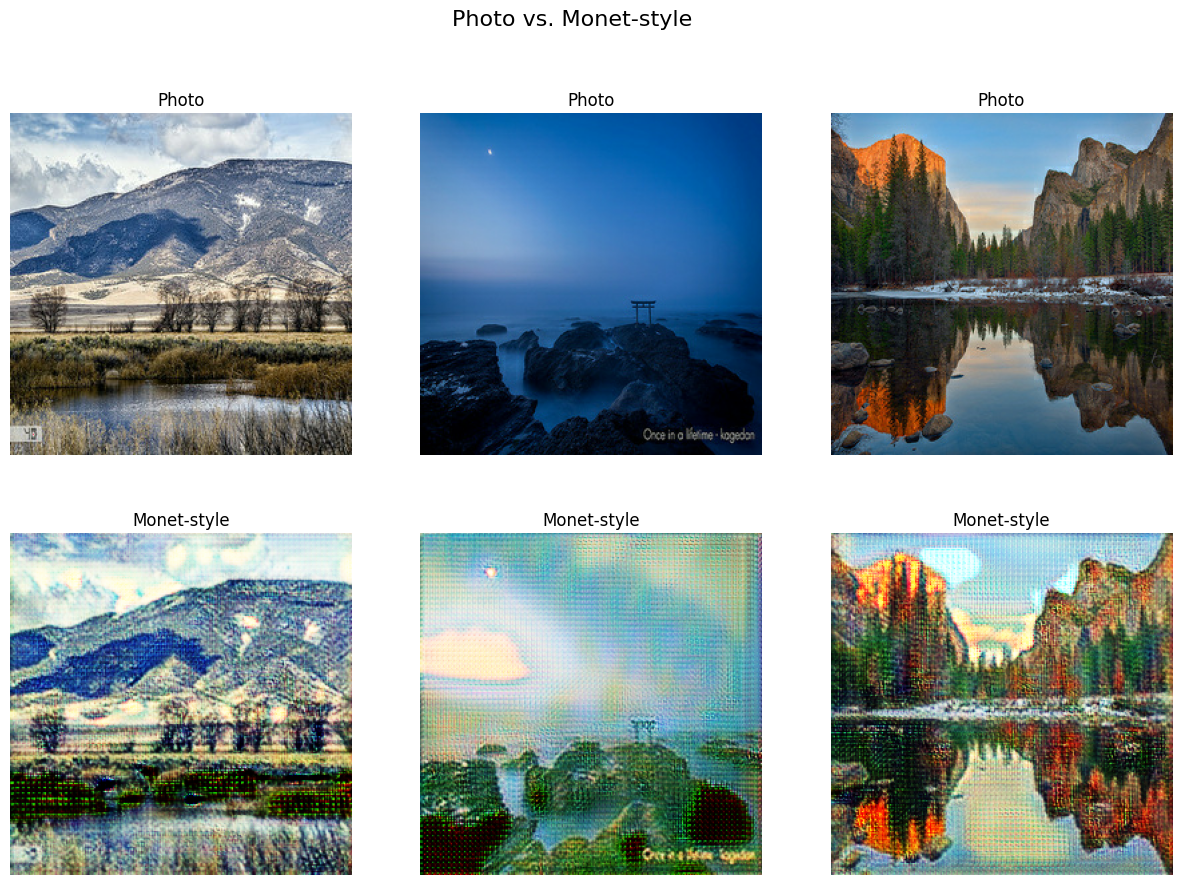

In [14]:
# Extract generator_monet
generator_monet =  CycleGan2.GenM

# Visualize the Photos vs. Monet-style photos 
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 10))
fig.suptitle('Photo vs. Monet-style', fontsize = 16)
for i, img in enumerate(photo_ds.take(3)):
    generated_img = generator_monet(img, training = False)[0].numpy()
    generated_img = (generated_img * 127.5 + 127.5).astype(np.uint8)
    img = tf.cast(img * 127.5 + 127.5, tf.uint8).numpy()
    img = np.squeeze(img, axis=0)
    ax[0, i].imshow(img)
    ax[0, i].set_title('Photo')
    ax[0, i].axis('off')
    ax[1, i].imshow(generated_img)
    ax[1, i].set_title('Monet-style')
    ax[1, i].axis('off')
plt.show()

### Submit the Generated images

In [15]:
import PIL
import shutil

# Create the folder to save generated images
os.makedirs('../images/')

# Generate monet-style images
i = 1
for img in photo_ds:
    generated_img = generator_monet(img, training = False)[0].numpy()
    generated_img = (generated_img * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(generated_img)
    im.save("../images/" + str(i) + '.jpg')
    i += 1

print(f"Generated images: {len([name for name in os.listdir('../images') if os.path.isfile(os.path.join('../images', name))])}")

# archive the image folder
shutil.make_archive('/kaggle/working/images', 'zip', '../images')

Generated images: 7038


'/kaggle/working/images.zip'